In [16]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import os
import copy
from glob import glob
import cv2
import shutil
import time

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [17]:
def load_dataset(rel_path='.', mode="train", resize=False, resize_shape=(256, 256)):
    
    if os.path.exists(f"datasets/{mode}/image.npy") and \
        os.path.exists(f"datasets/{mode}/label.npy") and \
        os.path.exists(f"datasets/{mode}/mask.npy"):
        
        new_input_tensor = np.load(f"datasets/{mode}/image.npy")
        new_label_tensor = np.load(f"datasets/{mode}/label.npy")
        new_mask_tensor = np.load(f"datasets/{mode}/mask.npy")
        return new_input_tensor, new_label_tensor, new_mask_tensor

    train_image_files = sorted(glob(os.path.join(rel_path, f'data/{mode}/img/*')))  #choose img
    train_label_files = sorted(glob(os.path.join(rel_path, f'data/{mode}/segm/*'))) #choose segm
    train_mask_files = sorted(glob(os.path.join(rel_path, f'data/{mode}/mask/*'))) #choose mask
    
    for i, filename in enumerate(train_image_files):
        img = Image.open(filename)
        if resize:
            img = img.resize(resize_shape, Image.ANTIALIAS)
        imgmat = np.array(img).astype('float')
        imgmat = imgmat / 255.0
        if i == 0:
            input_tensor = np.expand_dims(imgmat, axis=0)
        else:
            tmp = np.expand_dims(imgmat, axis=0)
            input_tensor = np.concatenate((input_tensor, tmp), axis=0)
    new_input_tensor = np.moveaxis(input_tensor, 3, 1)
            
    for i, filename in enumerate(train_label_files):
        Img_label = Image.open(filename)
        if resize:
            Img_label = Img_label.resize(resize_shape, Image.ANTIALIAS)
            Img_label = Img_label.convert('1')
        label = np.array(Img_label)
        label = label / 1.0
        if i == 0:
            label_tensor = np.expand_dims(label, axis=0)
        else:
            tmp = np.expand_dims(label, axis=0)
            label_tensor = np.concatenate((label_tensor, tmp), axis=0)
    new_label_tensor = np.stack((label_tensor[:,:,:], 1 - label_tensor[:,:,:]), axis=1)
    
    for i, filename in enumerate(train_mask_files):
        Img_mask = Image.open(filename)
        if resize:
            Img_mask = Img_mask.resize(resize_shape, Image.ANTIALIAS)
            Img_mask = Img_mask.convert('1')
        mask = np.array(Img_mask)
        mask = mask / 1.0
        if i == 0:
            mask_tensor = np.expand_dims(mask, axis=0)
        else:
            tmp = np.expand_dims(mask, axis=0)
            mask_tensor = np.concatenate((mask_tensor, tmp), axis=0)
    new_mask_tensor = np.stack((mask_tensor[:,:,:], mask_tensor[:,:,:]), axis=1)
    
    if not os.path.exists("./datasets"):
        os.mkdir("./datasets")
    if not os.path.exists(f"./datasets/{mode}"):
        os.mkdir(f"./datasets/{mode}")
    np.save(f"datasets/{mode}/image.npy", new_input_tensor)
    np.save(f"datasets/{mode}/label.npy", new_label_tensor)
    np.save(f"datasets/{mode}/mask.npy", new_mask_tensor)
    
    return new_input_tensor, new_label_tensor, new_mask_tensor

In [18]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBNReLU, self).__init__()
        self.convbnrelu = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )          
    def forward(self, x):
        return self.convbnrelu(x)
    

class ConvNoPool(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvNoPool, self).__init__()
        self.convnopool = nn.Sequential(
            ConvBNReLU(in_ch, out_ch),
            ConvBNReLU(out_ch, out_ch)
        )        
    def forward(self, x):
        return self.convnopool(x)

    
class ConvPool(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(ConvPool, self).__init__()
        self.convpool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBNReLU(in_ch, out_ch),
            ConvBNReLU(out_ch, out_ch)
        )
    def forward(self, x):
        return self.convpool(x)
    
class UpsampleConv(nn.Module):
    def __init__(self, in_ch, out_ch, isDeconv=True):
        super(UpsampleConv, self).__init__()
        if isDeconv:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        else:
            self.up = nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor=2),
                nn.Conv2d(in_ch, out_ch, kernel_size=1)
            )
        self.convtwice = nn.Sequential(
            ConvBNReLU(in_ch, out_ch),
            ConvBNReLU(out_ch, out_ch)
        )
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[3] - x1.size()[3]
        diffY = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.convtwice(x)
        return x

class ConvOut(nn.Module):
    def __init__(self, in_ch):
        super(ConvOut, self).__init__()
        self.convout = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=1),
            nn.Conv2d(in_ch, in_ch, kernel_size=1),
            nn.Conv2d(in_ch, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output_ = self.convout(x)
        return output_
    
class Unet(nn.Module):
    def __init__(self, img_ch, fch_base=16, isDeconv=True):
        super(Unet, self).__init__()
        
        self.blocks = nn.ModuleList()
        
        self.down1 = ConvNoPool(img_ch, fch_base)
        self.down2 = ConvPool(fch_base, fch_base * 2)
        self.down3 = ConvPool(fch_base * 2, fch_base * 4)
        self.down4 = ConvPool(fch_base * 4, fch_base * 8)
        
        self.encoder = ConvPool(fch_base * 8, fch_base * 16)
        
        self.up1 = UpsampleConv(fch_base * 16 , fch_base * 8, isDeconv)
        self.up2 = UpsampleConv(fch_base * 8, fch_base * 4, isDeconv)
        self.up3 = UpsampleConv(fch_base * 4, fch_base * 2 , isDeconv)
        self.up4 = UpsampleConv(fch_base * 2, fch_base, isDeconv)
        
        self.out = ConvOut(fch_base)
        
        self.blocks = nn.ModuleList([self.down1, self.down2, self.down3,\
                                     self.down4, self.encoder, self.up1, self.up2,\
                                     self.up3, self.up4, self.out])

    def forward(self, input_):
        d1 = self.down1(input_)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        enc = self.encoder(d4)
        u1 = self.up1(enc, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        output_ = self.out(u4)
        return output_

In [19]:
from sklearn.metrics import roc_auc_score

def eval_print_metrics(bat_label, bat_pred, bat_mask):
    assert len(bat_label.size()) == 4 and len(bat_pred.size()) == 4
    assert bat_label.size()[1] == 1 and bat_pred.size()[1] == 1
    
    masked_pred = bat_pred * bat_mask
    masked_label = bat_label * bat_mask
    masked_pred_class = (masked_pred > 0.35).float()
    
    precision = float(torch.sum(masked_pred_class * masked_label)) / (float(torch.sum(masked_pred_class)) + 1)
    recall = float(torch.sum(masked_pred_class * masked_label)) / (float(torch.sum(masked_label.float())) + 1)
    f1_score = 2.0 * precision * recall / (precision + recall + 1e-8)
    
    pred_ls = bat_pred.detach().numpy()
    label_ls = np.array(bat_label.detach(), dtype=int)

    pred_ls = np.array(bat_pred[bat_mask > 0].detach())
    label_ls = np.array(bat_label[bat_mask > 0].detach(), dtype=int)
    try:
        bat_auc = roc_auc_score(label_ls, pred_ls)
    except ValueError:
        bat_auc = 0

    print("precision: {:.4f} recall: {:.4f} f1_score: {:.4f} auc: {:.4f}".format(precision, recall, f1_score, bat_auc))

    return precision, recall, f1_score, bat_auc

def paste_and_save(bat_img, bat_label, bat_pred_class, batch_size, cur_bat_num, save_img='pred_imgs'):
    w, h = bat_img.size()[2:4]
    for bat_id in range(bat_img.size()[0]):
        img = Image.fromarray(np.moveaxis(np.array(bat_img * 255.0, dtype=np.uint8)[bat_id, :, :, :], 0, 2))
        label = Image.fromarray(np.array(bat_label * 255.0, dtype=np.uint8)[bat_id, 0, :, :])
        pred_class = Image.fromarray(np.array(bat_pred_class * 255.0, dtype=np.uint8)[bat_id, 0, :, :])
        
        res_id = (cur_bat_num - 1) * batch_size + bat_id
        target = Image.new('RGB', (3 * w, h))
        target.paste(img, box = (0, 0))
        target.paste(label, box = (w, 0))
        target.paste(pred_class, box = (2 * w, 0))
        
        target.save(os.path.join(save_img, "result_{}.png".format(res_id)))
    return target


In [20]:
# set parameters for training
EPOCHS = 50
BATCH_SIZE = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet_ins = Unet(img_ch=3, isDeconv=True)
unet_ins.to(device)

criterion = nn.BCELoss()
# criterion =  torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')

optimizer = torch.optim.SGD(unet_ins.parameters(), lr=0.1)

In [21]:
import warnings
warnings.filterwarnings('ignore')

def model_train(net, optimizer, criterion, epochs=50, batch_size=2):
    
    since = time.time()
    train_loss_list = []
    train_prec_list = []
    valid_loss_list = []
    valid_prec_list = []
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_epoch_avg_loss = float('inf')
    
    for epoch in range(epochs):
        epoch_tot_loss = 0
        print(f'Epoch [{epoch + 1}/{epochs}]')
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()  
            else:
                net.eval()
            
            x_tensor, y_tensor, m_tensor = load_dataset(mode=phase, resize=True, resize_shape=(256, 256))
    
            num_samples = x_tensor.shape[0]
        
            num_iters = int(np.ceil(num_samples / batch_size))
            shuffle_ids = np.random.permutation(num_samples)
            x_tensor = x_tensor[shuffle_ids, :, :, :]
            y_tensor = y_tensor[shuffle_ids, :, :, :]

            for ite in range(num_iters):
                if not ite == num_iters - 1:
                    start_id, end_id = ite * batch_size, (ite + 1) * batch_size
                    bat_img = torch.Tensor(x_tensor[start_id : end_id, :, :, :])
                    bat_label = torch.Tensor(y_tensor[start_id : end_id, 0: 1, :, :])
                    bat_mask = torch.Tensor(m_tensor[start_id : end_id, 0: 1, :, :])
                else:
                    start_id = ite * batch_size
                    bat_img = torch.Tensor(x_tensor[start_id : , :, :, :])
                    bat_label = torch.Tensor(y_tensor[start_id : , 0: 1, :, :])
                    bat_mask = torch.Tensor(m_tensor[start_id : , 0: 1, :, :])

                optimizer.zero_grad()
                
                bat_img = bat_img.to(device)
                bat_label = bat_label.to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    bat_pred = net(bat_img)
                    loss = criterion(bat_pred, bat_label.float())
                    # masked_pred = bat_pred * bat_mask
                    # masked_label = bat_label * bat_mask
                    # loss = criterion(masked_pred, masked_label.float(), reduction='mean')

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()                     

                if not ite == num_iters - 1:
                    epoch_tot_loss += loss.item()
                else:
                    epoch_tot_loss += loss.item()
                    epoch_avg_loss = epoch_tot_loss / (ite + 1)
                    plint = phase if phase == 'train' else 'valid'
                    print("{} avg_loss : {:.4f} ".format(plint, epoch_avg_loss), end = '')
                    prec, _, _, _ = eval_print_metrics(bat_label.to('cpu'), bat_pred.to('cpu'), bat_mask)
                
            if phase == 'train':
                train_loss_list.append(epoch_avg_loss)
                train_prec_list.append(prec)
            else:
                valid_loss_list.append(epoch_avg_loss)
                valid_prec_list.append(prec)
                
            if phase == 'val' and epoch_avg_loss < best_epoch_avg_loss:
                best_epoch_avg_loss = epoch_avg_loss
                best_model_wts = copy.deepcopy(net.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_epoch_avg_loss:4f}')
    xepoch = np.arange(epochs, dtype=int)+1
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, layout="constrained")
    
    ax1.plot(xepoch, train_loss_list, label='train')
    ax1.plot(xepoch, valid_loss_list, label='valid')
    ax1.legend(loc="center right")
    ax1.set_ylabel('loss')
    
    ax2.plot(xepoch, train_prec_list, label='train')
    ax2.plot(xepoch, valid_prec_list, label='valid')
    ax2.legend(loc="center right")
    ax2.set_ylabel('precision')
    plt.plot()
    
    net.load_state_dict(best_model_wts)
    return net


Epoch [1/10]
train avg_loss : 0.1037 precision: 0.7127 recall: 0.8136 f1_score: 0.7598 auc: 0.9703
valid avg_loss : 0.4606 precision: 0.7995 recall: 0.8589 f1_score: 0.8282 auc: 0.9789
Epoch [2/10]
train avg_loss : 0.1033 precision: 0.8559 recall: 0.8687 f1_score: 0.8623 auc: 0.9862
valid avg_loss : 0.4557 precision: 0.8645 recall: 0.8534 f1_score: 0.8589 auc: 0.9846
Epoch [3/10]
train avg_loss : 0.1032 precision: 0.7480 recall: 0.9022 f1_score: 0.8179 auc: 0.9870
valid avg_loss : 0.4660 precision: 0.7683 recall: 0.9320 f1_score: 0.8423 auc: 0.9888
Epoch [4/10]
train avg_loss : 0.1027 precision: 0.7297 recall: 0.7857 f1_score: 0.7567 auc: 0.9614
valid avg_loss : 0.4549 precision: 0.7524 recall: 0.7033 f1_score: 0.7270 auc: 0.9574
Epoch [5/10]
train avg_loss : 0.1026 precision: 0.8254 recall: 0.8368 f1_score: 0.8311 auc: 0.9761
valid avg_loss : 0.4535 precision: 0.8819 recall: 0.8491 f1_score: 0.8652 auc: 0.9874
Epoch [6/10]
train avg_loss : 0.1020 precision: 0.8422 recall: 0.8838 f1_sc

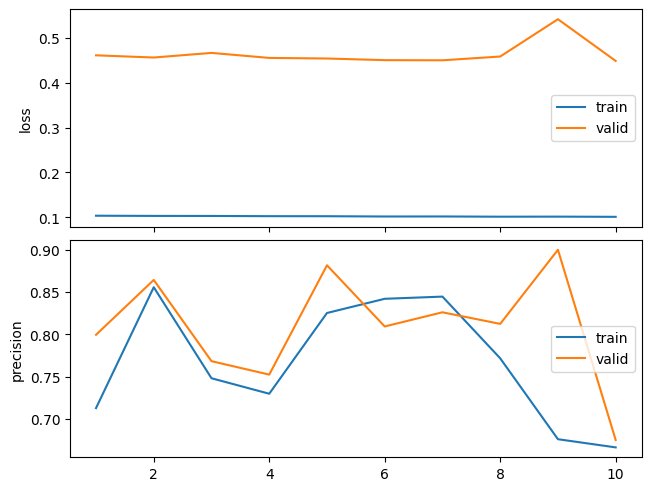

In [23]:
trained_unet = model_train(unet_ins, optimizer, criterion, batch_size=BATCH_SIZE, epochs=10)

In [24]:
def model_test(net, batch_size=2):
    
    x_tensor, y_tensor, m_tensor = load_dataset(mode='test', resize=True, resize_shape=(256, 256))
    num_samples = x_tensor.shape[0]
    num_iters = int(np.ceil(num_samples / batch_size))
    prec_cul = 0
    rec_cul = 0
    f1_cul = 0
    auc_cul = 0
    for ite in range(num_iters):
        print("predicting on the {}th batch".format(ite + 1))
        if not ite == num_iters - 1:
            start_id, end_id = ite * batch_size, (ite + 1) * batch_size
            bat_img = torch.Tensor(x_tensor[start_id : end_id, :, :, :])
            bat_label = torch.Tensor(y_tensor[start_id : end_id, 0: 1, :, :])
            bat_mask = torch.Tensor(m_tensor[start_id : end_id, 0: 1, :, :])
        else:
            start_id = ite * batch_size
            bat_img = torch.Tensor(x_tensor[start_id : , :, :, :])
            bat_label = torch.Tensor(y_tensor[start_id : , 0: 1, :, :])
            bat_mask = torch.Tensor(m_tensor[start_id : , 0: 1, :, :])
            
        bat_pred = net(bat_img.to(device))
        bat_pred = bat_pred.to('cpu')
        bat_pred_class = (bat_pred > 0.35).float() * bat_mask
        
        prec, rec, f1, auc = eval_print_metrics(bat_label, bat_pred, bat_mask)
        prec_cul += prec
        rec_cul += rec
        f1_cul += f1
        auc_cul += auc
        aa = paste_and_save(bat_img, bat_label, bat_pred_class, batch_size, ite + 1)
        plt.imshow(aa)
        plt.title('last image in batch')
        plt.axis('off')
        plt.show()
    print("Testing average\nprecision: {:.2f} % recall: {:.2f} % f1_score: {:.4f} auc: {:.4f}".format(100*prec_cul/num_iters, 100*rec_cul/num_iters, f1_cul/num_iters, auc_cul/num_iters))

    return

if os.path.exists("./pred_imgs"):
    shutil.rmtree("./pred_imgs")
os.mkdir("./pred_imgs")


predicting on the 1th batch
precision: 0.6201 recall: 0.6936 f1_score: 0.6548 auc: 0.9445


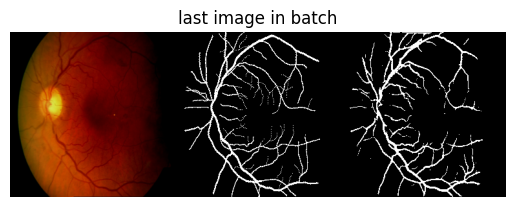

predicting on the 2th batch
precision: 0.6434 recall: 0.8278 f1_score: 0.7241 auc: 0.9589


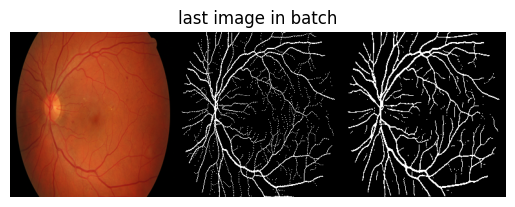

predicting on the 3th batch
precision: 0.7235 recall: 0.7839 f1_score: 0.7525 auc: 0.9496


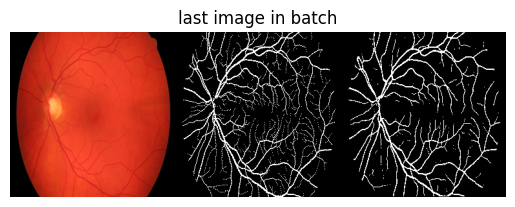

predicting on the 4th batch
precision: 0.7126 recall: 0.8125 f1_score: 0.7593 auc: 0.9589


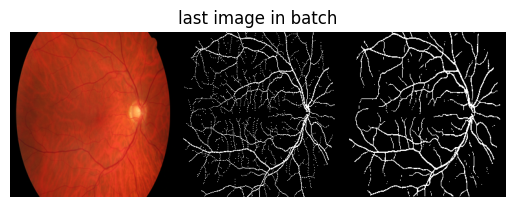

predicting on the 5th batch
precision: 0.5526 recall: 0.6941 f1_score: 0.6153 auc: 0.9313


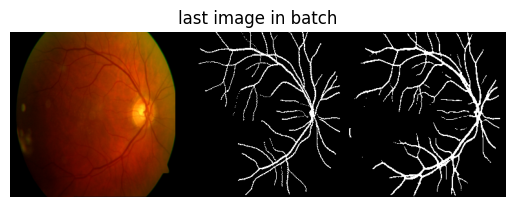

predicting on the 6th batch
precision: 0.7209 recall: 0.6958 f1_score: 0.7081 auc: 0.9509


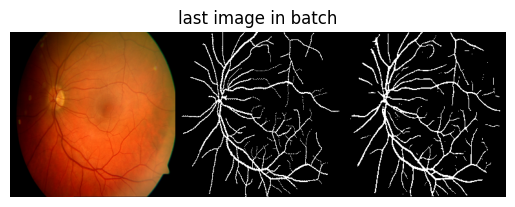

predicting on the 7th batch
precision: 0.6712 recall: 0.7964 f1_score: 0.7285 auc: 0.9610


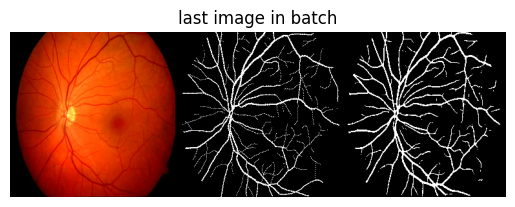

predicting on the 8th batch
precision: 0.6827 recall: 0.7692 f1_score: 0.7234 auc: 0.9610


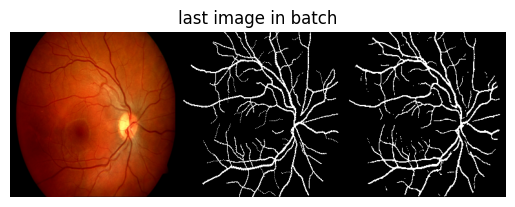

predicting on the 9th batch
precision: 0.7508 recall: 0.7194 f1_score: 0.7348 auc: 0.9609


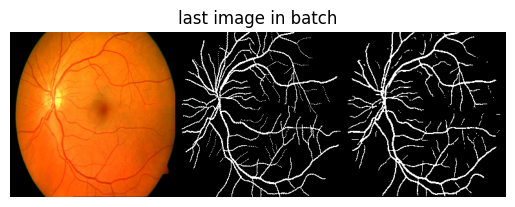

predicting on the 10th batch
precision: 0.7015 recall: 0.7364 f1_score: 0.7185 auc: 0.9583


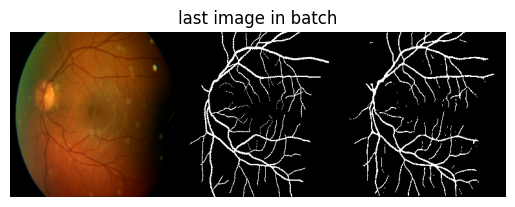

predicting on the 11th batch
precision: 0.6293 recall: 0.7724 f1_score: 0.6935 auc: 0.9621


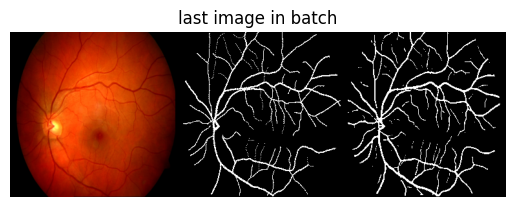

predicting on the 12th batch
precision: 0.3813 recall: 0.4144 f1_score: 0.3971 auc: 0.7346


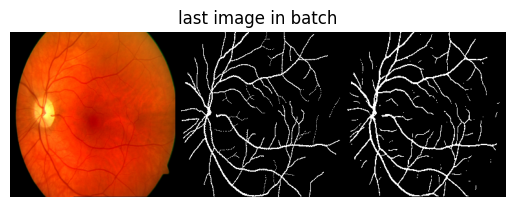

predicting on the 13th batch
precision: 0.3383 recall: 0.3951 f1_score: 0.3645 auc: 0.7273


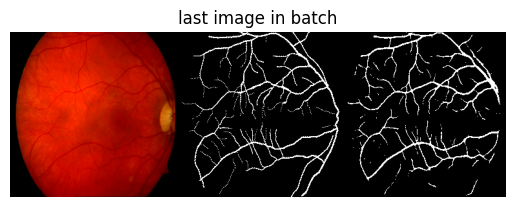

predicting on the 14th batch
precision: 0.6188 recall: 0.6517 f1_score: 0.6348 auc: 0.9328


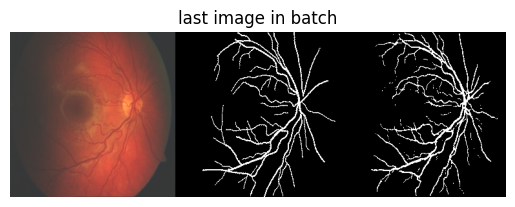

predicting on the 15th batch
precision: 0.5699 recall: 0.6187 f1_score: 0.5933 auc: 0.9207


predicting on the 16th batch
precision: 0.6708 recall: 0.7449 f1_score: 0.7059 auc: 0.9564


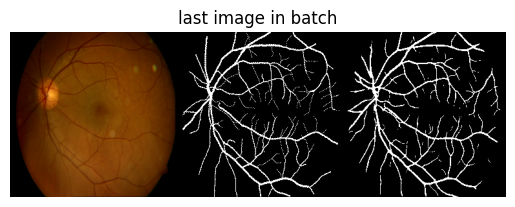

predicting on the 17th batch
precision: 0.7650 recall: 0.7718 f1_score: 0.7684 auc: 0.9663


predicting on the 18th batch
precision: 0.5706 recall: 0.7517 f1_score: 0.6487 auc: 0.9504


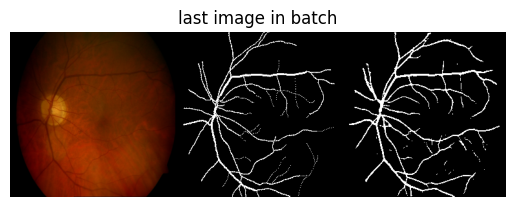

predicting on the 19th batch
precision: 0.5365 recall: 0.7066 f1_score: 0.6099 auc: 0.9555


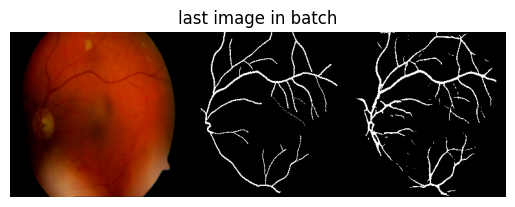

predicting on the 20th batch
precision: 0.5721 recall: 0.5424 f1_score: 0.5568 auc: 0.8344


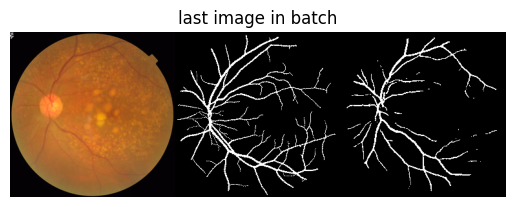

predicting on the 21th batch
precision: 0.4914 recall: 0.4638 f1_score: 0.4772 auc: 0.7864


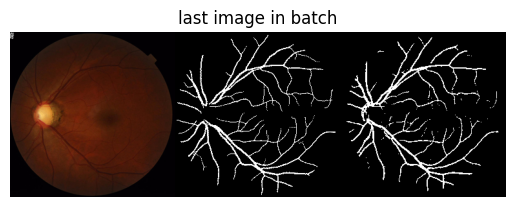

predicting on the 22th batch
precision: 0.1410 recall: 0.1650 f1_score: 0.1520 auc: 0.5427


predicting on the 23th batch
precision: 0.1065 recall: 0.0815 f1_score: 0.0923 auc: 0.4899


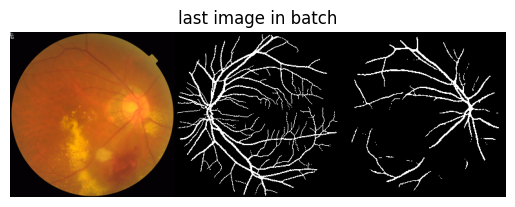

predicting on the 24th batch
precision: 0.4950 recall: 0.4815 f1_score: 0.4881 auc: 0.6872


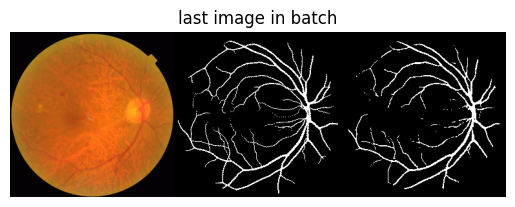

predicting on the 25th batch
precision: 0.8470 recall: 0.8251 f1_score: 0.8359 auc: 0.9656


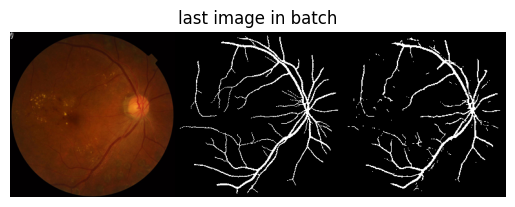

predicting on the 26th batch
precision: 0.8641 recall: 0.8854 f1_score: 0.8746 auc: 0.9914


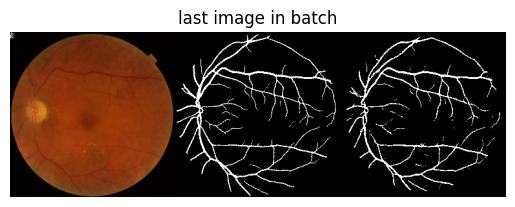

predicting on the 27th batch
precision: 0.8757 recall: 0.9002 f1_score: 0.8877 auc: 0.9913


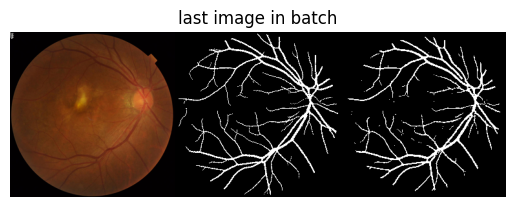

predicting on the 28th batch
precision: 0.8746 recall: 0.8294 f1_score: 0.8514 auc: 0.9875


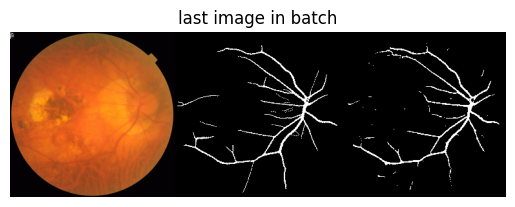

predicting on the 29th batch
precision: 0.8756 recall: 0.8724 f1_score: 0.8740 auc: 0.9882


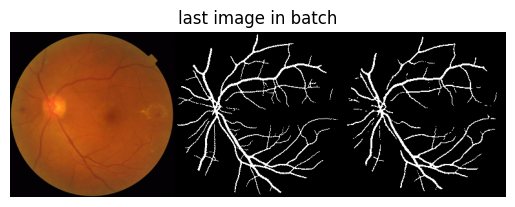

predicting on the 30th batch
precision: 0.8851 recall: 0.8326 f1_score: 0.8581 auc: 0.9788


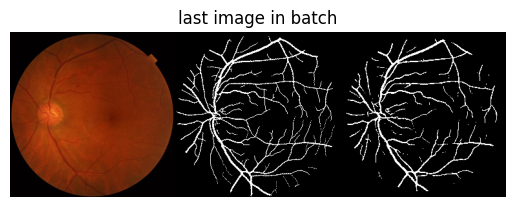

predicting on the 31th batch
precision: 0.8787 recall: 0.8653 f1_score: 0.8719 auc: 0.9887


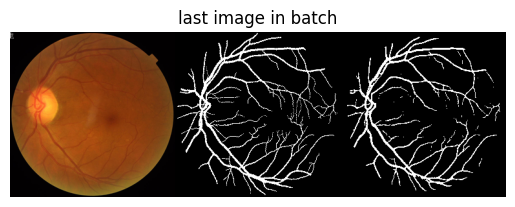

predicting on the 32th batch
precision: 0.5105 recall: 0.4950 f1_score: 0.5026 auc: 0.7855


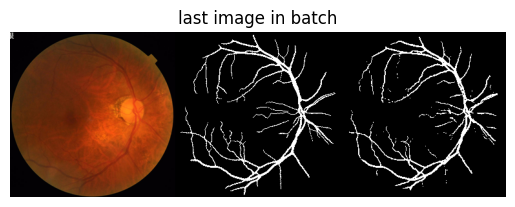

predicting on the 33th batch
precision: 0.8718 recall: 0.8636 f1_score: 0.8677 auc: 0.9903


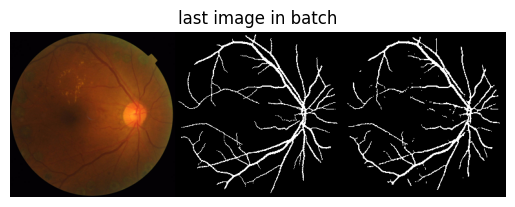

predicting on the 34th batch
precision: 0.8300 recall: 0.8833 f1_score: 0.8558 auc: 0.9842


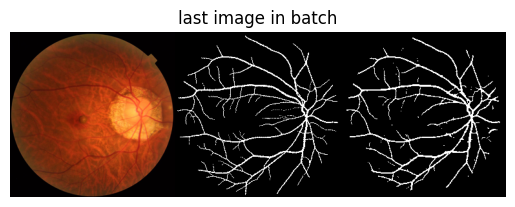

predicting on the 35th batch
precision: 0.8839 recall: 0.8476 f1_score: 0.8653 auc: 0.9859


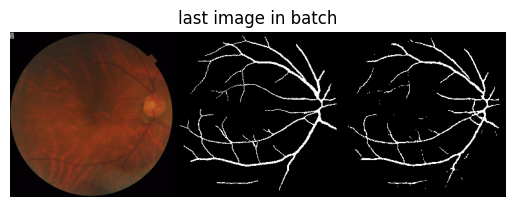

predicting on the 36th batch
precision: 0.8182 recall: 0.7663 f1_score: 0.7914 auc: 0.9678


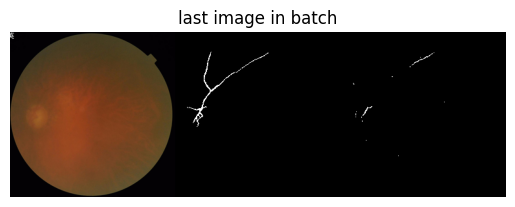

predicting on the 37th batch
precision: 0.8241 recall: 0.7913 f1_score: 0.8074 auc: 0.9640


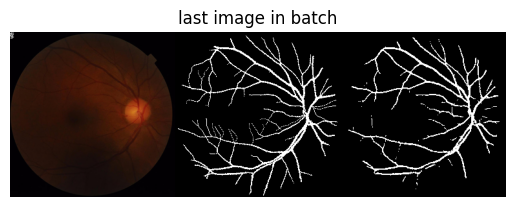

predicting on the 38th batch
precision: 0.7874 recall: 0.9173 f1_score: 0.8474 auc: 0.9917


predicting on the 39th batch
precision: 0.8195 recall: 0.8424 f1_score: 0.8308 auc: 0.9726


predicting on the 40th batch
precision: 0.8039 recall: 0.8736 f1_score: 0.8373 auc: 0.9849


predicting on the 41th batch
precision: 0.8497 recall: 0.8779 f1_score: 0.8636 auc: 0.9889


predicting on the 42th batch
precision: 0.7909 recall: 0.8506 f1_score: 0.8196 auc: 0.9812


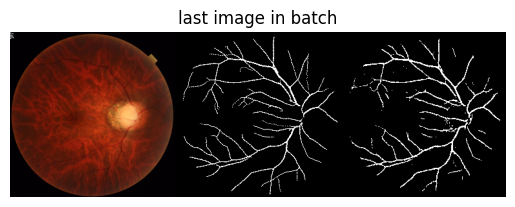

predicting on the 43th batch
precision: 0.5981 recall: 0.7864 f1_score: 0.6794 auc: 0.9615


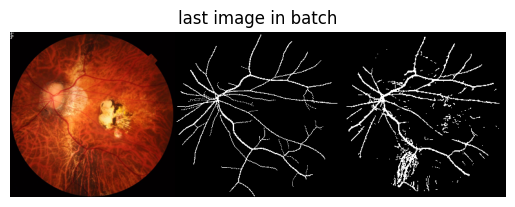

predicting on the 44th batch
precision: 0.7955 recall: 0.9039 f1_score: 0.8462 auc: 0.9898


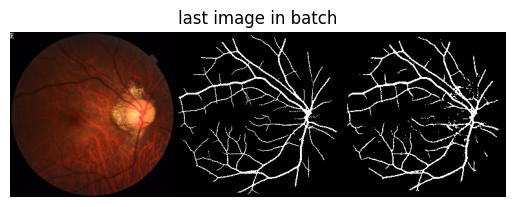

predicting on the 45th batch
precision: 0.7936 recall: 0.8763 f1_score: 0.8329 auc: 0.9883


predicting on the 46th batch
precision: 0.8679 recall: 0.8794 f1_score: 0.8736 auc: 0.9862


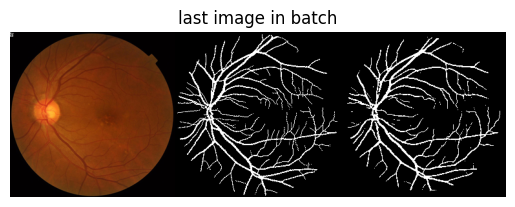

predicting on the 47th batch
precision: 0.8868 recall: 0.8915 f1_score: 0.8891 auc: 0.9921


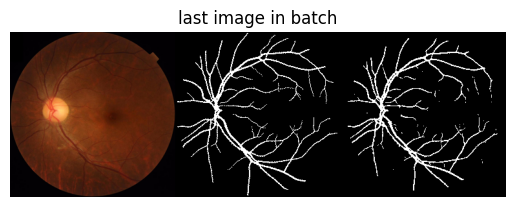

predicting on the 48th batch
precision: 0.8772 recall: 0.9035 f1_score: 0.8902 auc: 0.9915


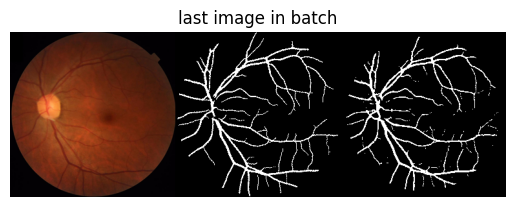

predicting on the 49th batch
precision: 0.8601 recall: 0.9105 f1_score: 0.8846 auc: 0.9915


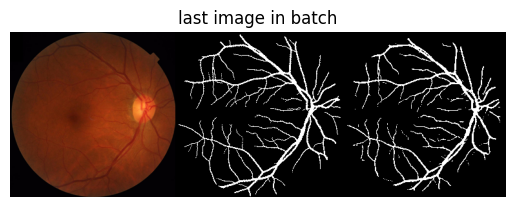

predicting on the 50th batch
precision: 0.8728 recall: 0.8878 f1_score: 0.8803 auc: 0.9915


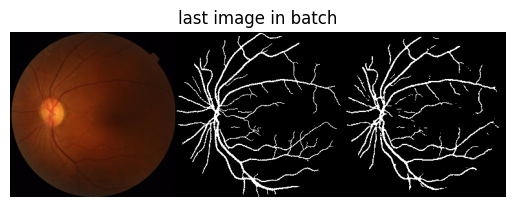

predicting on the 51th batch
precision: 0.8409 recall: 0.9075 f1_score: 0.8729 auc: 0.9907


predicting on the 52th batch
precision: 0.8148 recall: 0.8696 f1_score: 0.8413 auc: 0.9838


predicting on the 53th batch
precision: 0.8574 recall: 0.9141 f1_score: 0.8848 auc: 0.9916


predicting on the 54th batch
precision: 0.8894 recall: 0.8945 f1_score: 0.8919 auc: 0.9930


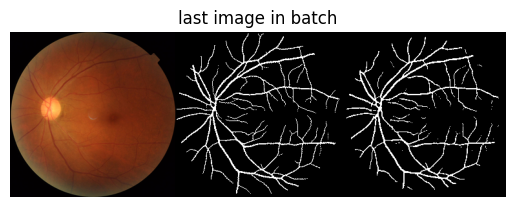

predicting on the 55th batch
precision: 0.8621 recall: 0.7926 f1_score: 0.8259 auc: 0.9785


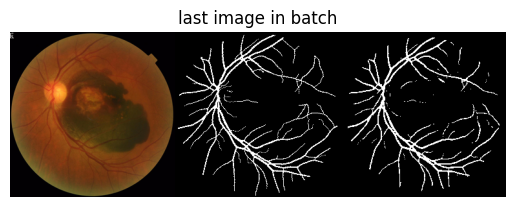

predicting on the 56th batch
precision: 0.8922 recall: 0.8552 f1_score: 0.8733 auc: 0.9892


predicting on the 57th batch
precision: 0.7257 recall: 0.8730 f1_score: 0.7926 auc: 0.9742


predicting on the 58th batch
precision: 0.8502 recall: 0.8934 f1_score: 0.8713 auc: 0.9874


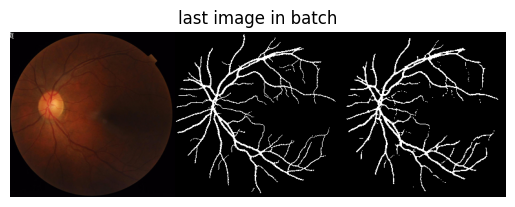

Testing average
precision: 72.14 % recall: 76.12 % f1_score: 0.7392 auc: 0.9354


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
a = model_test(trained_unet, batch_size=2)
shutil.rmtree('./datasets')

In [26]:
# torch.save(trained_unet.state_dict(), 'models/unet_100epochs_data.pt')

# model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier  = nn.Linear(num_ftrs, len(class_names))
# model_ft.load_state_dict(torch.load('models/dens_4b_24e_17m.pt'))

torch.cuda.empty_cache()